# Прототип RAG-агента для поиска терапевтических таргетов при болезни Альцгеймера

## Цель работы

Цель данного проекта — разработать прототип Retrieval-Augmented Generation (RAG)-агента для помощи исследователям в поиске **потенциальных терапевтических мишеней для лечения болезни Альцгеймера** на основе анализа научной литературы.

Система предназначена для:
- поиска релевантных научных публикаций из открытых биомедицинских источников,
- обработки и очистки неструктурированных текстов статей,
- генерации кратких и обоснованных ответов на исследовательские вопросы,
- предоставления прозрачных ссылок на источники, используемые при генерации ответа.

Прототип ориентирован на задачи **ранней генерации гипотез** и **исследовательского анализа литературы**, а не на клиническое принятие решений.

---

## Область применения

Разрабатываемый RAG-пайплайн включает следующие этапы:
- сбор научных статей, связанных с болезнью Альцгеймера,
- предобработку и разбиение текста на смысловые фрагменты,
- построение векторного индекса для семантического поиска,
- генерацию ответов с использованием языковой модели,
- явное указание источников для каждого ответа.

Подход демонстрирует, как retrieval-augmented generation может быть использован для поддержки исследований в области **поиска лекарственных мишеней при нейродегенеративных заболеваниях**.

---

## Структура ноутбука

Ноутбук организован следующим образом:

## 1. Сбор и исследовательский анализ данных (EDA)
Загрузка статей по болезни Альцгеймера, очистка текстов и первичный анализ корпуса.

## 2. Реализация RAG-системы
Векторизация текстов, построение FAISS-индекса и генерация ответов на исследовательские вопросы.

## 3. Оценка качества (Evaluation)

Оценка качества работы RAG-системы с использованием метрик Precision@5 и Recall@5 для retrieval, а также Faithfulness и Answer Relevance для оценки качества сгенерированных ответов.

## 4. Интерфейс пользователя (Streamlit)
Простой веб-интерфейс для ввода запросов и просмотра ответов с источниками.

## 5. Выводы


## 1. Подготовка и разведочный анализ данных (EDA)

Здесь выполняется очистка абстрактов и их анализ

In [1]:
import requests
import pandas as pd
from tqdm import tqdm
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from collections import Counter
import seaborn as sns
import html
import os

Подготавливаем инструменты для обработки текстов и визуализации данных.

In [2]:
nltk.download("stopwords")
nltk.download('punkt_tab')
stop_words = set(stopwords.words("english"))
sns.set_theme(style="whitegrid", palette="viridis")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Загружаем научные статьи из Europe PMC (*Europe PMC выбрал, потому что у него удобный API и он сразу даёт много open-access биомедицинских статей с нормальными метаданными*), преобразуем их в табличный формат и выполняем базовую очистку текстов абстрактов (удаление HTML-разметки, ссылок и лишних символов) для дальнейшего анализа и векторизации.

In [3]:
BASE_URL = "https://www.ebi.ac.uk/europepmc/webservices/rest/search"

def search_europe_pmc(query, max_results):
    params = {
        "query": query,
        "format": "json",
        "pageSize": max_results,
        "resultType": "core",
        "openAccess": "Y"
    }

    response = requests.get(BASE_URL, params=params)
    response.raise_for_status()

    data = response.json()
    return data["resultList"]["result"]

def articles_to_df(articles):
    rows = []

    for article in articles:
        rows.append({
            "title": article.get("title"),
            "abstract": article.get("abstractText"),
            "year": article.get("pubYear"),
            "authors": article.get("authorString")
        })

    return pd.DataFrame(rows)

def clean_text(text):
    text = html.unescape(text)
    text = re.sub(r"<[^>]+>", " ", text)
    text = re.sub(r"&lt;/?[a-zA-Z]+&gt;", " ", text)
    text = re.sub(r"\[\s*\d+(?:[\-,]\s*\d+)*\s*\]", " ", text)
    text = re.sub(r"(?i)references.*$", "", text)
    text = re.sub(r"\n+", " ", text)
    return re.sub(r"\s{2,}", " ", text).strip()

In [4]:
articles = search_europe_pmc(
    '("Alzheimer disease" OR "Alzheimer\'s disease") AND target',
    max_results=100)

df = articles_to_df(articles)
df = df.dropna(subset=["abstract"])
df["clean_abstract"] = df["abstract"].apply(clean_text)
df["clean_title"] = df["title"].apply(clean_text)
df["text_len"] = df["clean_abstract"].str.len()
df["word_count"] = df["clean_abstract"].str.split().str.len()
df.head()

,title,abstract,year,authors,clean_abstract,clean_title,text_len,word_count
0,In silico exploration of antioxidants as oxida...,To find efficient antioxidants to protect oxid...,2023,"Wilson Alphonse CR, Kannan RR.",To find efficient antioxidants to protect oxid...,In silico exploration of antioxidants as oxida...,1458,217
1,Network pharmacology and molecular simulations...,"<h4>Background</h4>Alzheimer's disease (AD), t...",2025,"Usmani SA, Ishaq S, Majeed A, Zaman Q, Aziz A,...","Background Alzheimer's disease (AD), the prima...",Network pharmacology and molecular simulations...,1843,216
3,Similarities and differences between Alzheimer...,<b>Background:</b> Alzheimer's disease (AD) an...,2026,"Zhang Y, Shao J, Liang B, He Y, Wen Z, Cai B, ...",Background: Alzheimer's disease (AD) and schiz...,Similarities and differences between Alzheimer...,923,121
4,PACAP: A promising disease-modifying target fo...,Alzheimer's disease (AD) is a significant publ...,2025,"Basri R, Al-Kuraishy HM, Fawzy MN, Alruwaili M...",Alzheimer's disease (AD) is a significant publ...,PACAP: A promising disease-modifying target fo...,1616,206
5,Recent Advances of the Role of Dl-3-n-Butylpht...,Alzheimer's disease (AD) is a prevalent neurod...,2026,"Huang H, Wu J, Fang Z, Wang Y, Xie J, Guan Y.",Alzheimer's disease (AD) is a prevalent neurod...,Recent Advances of the Role of Dl-3-n-Butylpht...,1558,189


В датасете 94 абстракта и в среднем каждый содержит около 200 слов что соответствует примерно 1500 символам. Большая часть текстов довольно однородна по размеру медианное значение практически совпадает со средним что говорит об отсутствии сильного перекоса. Большинство абстрактов укладываются в диапазон примерно от 160 до 240 слов при этом встречаются как более короткие так и более длинные тексты но они редкие. В целом размер текстов стабильный и хорошо подходит для RAG.

In [5]:
df[["text_len", "word_count"]].describe()

,text_len,word_count
count,94.000000,94.000000
mean,1492.287234,197.372340
std,397.448194,50.591551
min,313.000000,42.000000
25%,1229.000000,159.250000
50%,1477.000000,198.000000
75%,1780.250000,231.500000
max,2741.000000,353.000000


Большинство абстрактов имеют схожую длину и укладываются примерно в диапазон от 150 до 250 слов с наиболее частой длиной около 200 слов. Распределение выглядит достаточно гладким и однородным без резких скачков что говорит о том что корпус состоит из текстов одного типа и формата. Есть небольшое количество очень коротких абстрактов а также несколько более длинных но они встречаются редко и не влияют на общую картину. В целом тексты достаточно информативные и равномерные по объему что хорошо подходит для последующей нарезки на чанки.

Text(0.5, 1.0, 'Распределение длины Abstracts по словам')

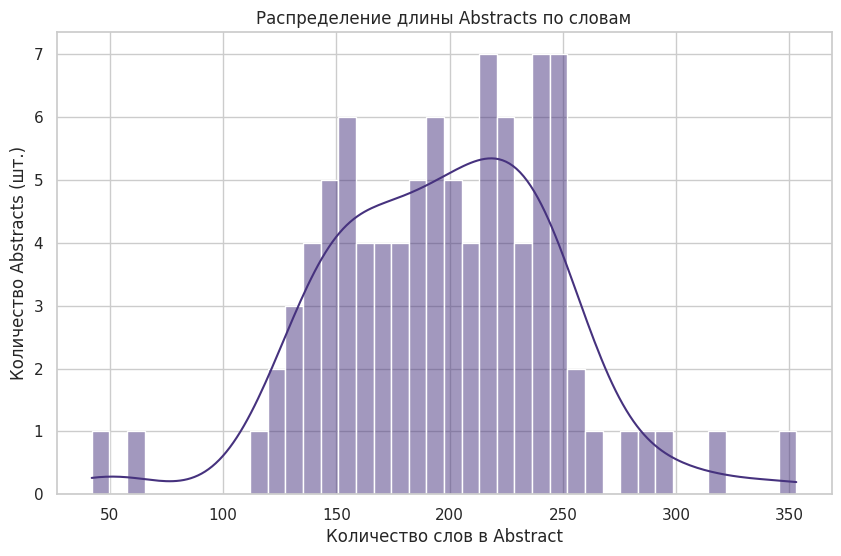

In [6]:
plt.figure(figsize=(10, 6))

sns.histplot(
    df["word_count"],
    bins=40,
    kde=True)

plt.xlabel("Количество слов в Abstract")
plt.ylabel("Количество Abstracts (шт.)")
plt.title("Распределение длины Abstracts по словам")

Если совсем просто то в текстах чаще всего встречаются слова напрямую связанные с болезнью Альцгеймера и лечением вроде alzheimer disease therapeutic target и potential. Помимо этого много общих научных слов про исследования эффекты активность и роль, а также часто мелькают термины связанные с мозгом и нервной системой. В целом по этим словам видно что статьи действительно про Альцгеймер и поиск способов его лечения а не про что то постороннее.

Text(0, 0.5, 'Термин')

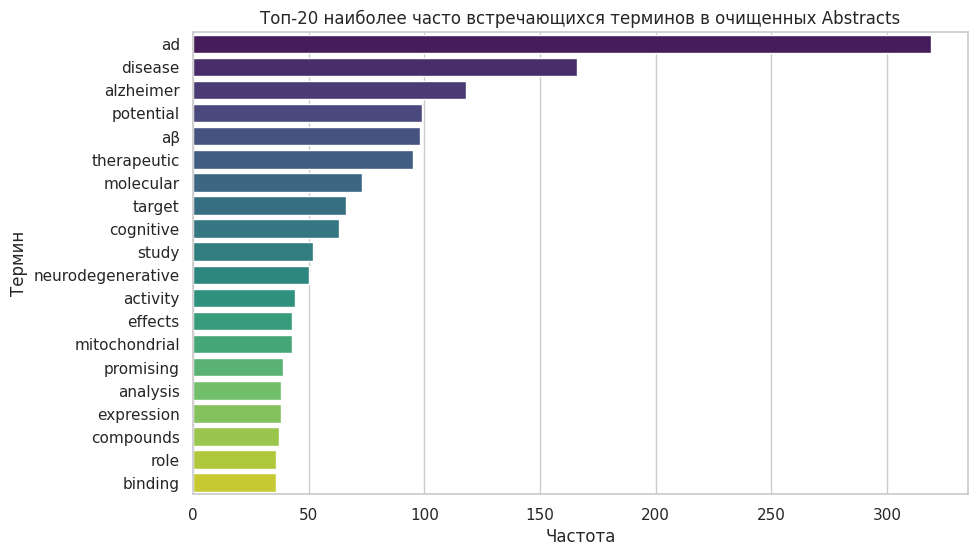

In [7]:
tokens = []
for text in df["clean_abstract"]:
    words = nltk.word_tokenize(text.lower())
    tokens.extend(w for w in words if w.isalpha() and w not in stop_words)

top_words = Counter(tokens).most_common(20)

freq_df = pd.DataFrame(top_words, columns=["word", "count"])

plt.figure(figsize=(10, 6))

sns.barplot(
    data=freq_df,
    x="count",
    y="word",
    hue="word",
    legend=False,
    palette='viridis'
)

plt.title("Топ-20 наиболее часто встречающихся терминов в очищенных Abstracts")
plt.xlabel("Частота")
plt.ylabel("Термин")

Text(0.5, 1.0, 'Облако наиболее частотных слов в абстрактах по болезни Альцгеймера')

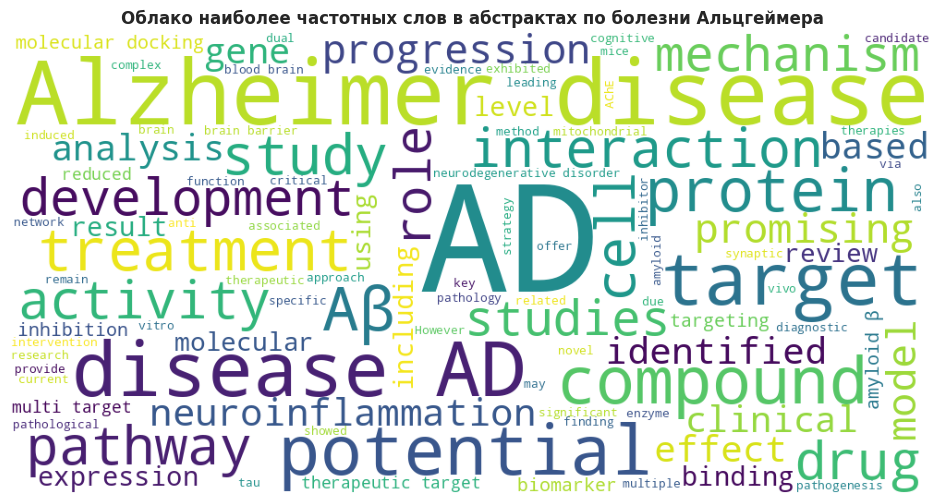

In [8]:
text = " ".join(df["clean_abstract"].dropna())

wordcloud = WordCloud(
    width=1000,
    height=500,
    background_color="white",
    stopwords=stop_words,
    max_words=100
).generate(text)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud)
plt.axis("off")
plt.title("Облако наиболее частотных слов в абстрактах по болезни Альцгеймера", fontweight="bold")

## 2. Реализация RAG системы

In [9]:
!pip install langchain_community
!pip install langchain_huggingface
!pip install langchain_text_splitters
!pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 39.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 53.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.1/489.1 kB 29.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 3.3 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.32.4
    Uninstalling requests-2.32.4:
      Successfully uninstalled requests-2.32.4
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 1.2.1
    Uninstalling langchain-core-1.2.1:
      Successfully uninstalled langchain-core-1.2.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is inc

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.8/23.8 MB 80.9 MB/s eta 0:00:00


In [10]:
from langchain_community.vectorstores import FAISS
from langchain_huggingface import HuggingFaceEmbeddings
import numpy as np
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.output_parsers import StrOutputParser
import os
from openai import OpenAI

Разбиваем абстракты по чанкам для поиска и сохраняем к ним метаданные, чтобы потом можно было показывать источники

In [11]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=800,
    chunk_overlap=150)

texts = []
metadatas = []

for _, row in df.iterrows():
    text = row["clean_abstract"]
    if not isinstance(text, str):
        continue

    for chunk in text_splitter.split_text(text):
        texts.append(chunk)
        metadatas.append({
            "title": row.get("title"),
            "authors": row.get("authors"),
            "year": row.get("year")
        })

В этой ячейке строю эмбеддинги для текстовых чанков и создаю FAISS-индекс для поиска похожих фрагментов. В качестве модели эмбеддингов выбрал BioBERT-based модель с HuggingFace, так как она обучена на биомедицинских текстах (статьи, абстракты, клинические данные) и лучше подходит для нашего датасета про болезнь Альцгеймера, чем универсальные модели. Искал модель именно под biomedical domain, чтобы поиск был более релевантным и учитывал специфическую терминологию.

In [12]:
embedding_model = HuggingFaceEmbeddings(
    model_name="pritamdeka/BioBERT-mnli-snli-scinli-scitail-mednli-stsb")

vectorstore = FAISS.from_texts(
    texts=texts,
    embedding=embedding_model,
    metadatas=metadatas
)

retriever = vectorstore.as_retriever(search_kwargs={"k": 5})

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/691 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/433M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/412 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/433M [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
# сохраняю векторы для деплоя
#vectorstore.save_local("faiss_index")

Тут я настраиваю промпт, чтобы модель не фантазировала и отвечала только на основе тех статей, которые мы ей передаём. Я специально прошу указывать номера источников, чтобы было понятно, откуда взята информация. Если в статьях нет ответа на вопрос, модель должна прямо сказать об этом, а не придумывать что-то своё. Такой формат нужен, потому что мы работаем с научными текстами, и важно, чтобы она негаллюцинировала.

In [15]:
PROMPT = """You are a scientific assistant.

Your task is to answer the question using ONLY the information from the context below.

STRICT RULES:
- Use ONLY facts explicitly stated in the context.
- DO NOT use any external knowledge.
- DO NOT make assumptions or generalizations.
- DO NOT add any information that is not directly supported by the context.
- If the context does not contain the answer, say exactly: "The provided context does not contain this information."
- Every statement in your answer MUST be directly supported by the context.

Context:
{context}

Question:
{question}

Answer:
"""

OPENROUTER_API_KEY = os.getenv("OPENROUTER_API_KEY")
client = OpenAI(
    api_key=OPENROUTER_API_KEY,
    base_url="https://openrouter.ai/api/v1"
)

Тут собираю RAG в одну функцию: по запросу подтягиваем через retriever топ-k самых релевантных чанков, склеиваем их в контекст, подставляем в промпт и отправляем в OpenRouter (выбрал модель от Xiaomi, потому что она сейчас в топе и имеет бесплатные токены вход/выход - для теста самое то). На выходе получаем ответ модели и список документов, чтобы потом показать источники. По сути - связка retrieval + LLM в одном месте.

In [16]:
def rag_answer(query, retriever, client, k=5):
    docs = retriever.invoke(query)[:k]

    context = "\n\n".join(
        [f"[{i+1}] {doc.page_content}" for i, doc in enumerate(docs)]
    )

    prompt_text = PROMPT.format(
        context=context,
        question=query
    )

    response = client.chat.completions.create(
        model="xiaomi/mimo-v2-flash:free",  # или другая модель
        messages=[
            {"role": "system", "content": "You are a helpful scientific assistant."},
            {"role": "user", "content": prompt_text}
        ],
        temperature=0.2
    )

    answer = response.choices[0].message.content.strip()

    return answer, docs

Проверка работоспособности. Немного подректировать бы красоту ответа и будет нормально -ничего необычного :)

In [17]:
answer, docs = rag_answer(
    "What are potential targets for Alzheimer's disease treatment?",
    retriever,
    client)

print(answer)

Based on the provided context, potential targets for Alzheimer's disease treatment include:

*   **AKT1, TNF, and STAT3:** These are common targets of *Kalanchoe pinnata* and AD that participate in the PI3K-Akt, MAP, and cAMP signaling pathways [2].
*   **TREM2:** This is targeted by the agonist peptide COG1410, which is part of the nanotherapeutic platform R@AClipo designed to enhance microglial-mediated Aβ clearance [4].
*   **Differentially expressed genes (DEGs):** These were identified through a meta-analysis of brain tissue transcriptome datasets to screen for potential AD drug targets [5].


In [18]:
for i, doc in enumerate(docs, 1):
    md = doc.metadata
    print(
        f"[{i}] {md['title']} — {md['authors']} ({md['year']})"
    )

[1] Bornyl Acetate and Menthol Provide Neuroprotection Against Lipopolysaccharide-Induced Alzheimer's Disease-Like Condition in C57BL/6 Mice by Downregulating NARC-1 Lipid Antagonist. — Krishnan M, Kumaresan M, Ravi S, Martin LC, Manikandan B, Raman T, Ramar M. (2025)
[2] Investigating the ameliorative effect of Kalanchoe pinnata on neuroinflammation-associated Alzheimer's disease using network pharmacology, molecular docking, and in vitro studies. — Khandayataray P, Murthy MK. (2025)
[3] Mechanism of Atractylodis Rhizoma in improving cognitive dysfunction in Alzheimer's disease by regulating the cAMP/CREB/BDNF pathway. — Xu X, Zhao Y, Ma H, Hu Y, Yu L, Su Y, Song J, Xie Z, Zhang Z, Wang P. (2026)
[4] Modulating Amyloid Pathology-Neural Hyperexcitability Crosstalk for Alzheimer's Disease Therapy. — Wang Y, Li J, Zhang D, Feng Y, Zhou M, Zhou C, Wang D, Qiu G, Dai W, Yang Z, Zhang Y, Zhang L, Liu X, Zhang J. (2025)
[5] &lt;i&gt;VEGFB&lt;/i&gt; is a potential therapeutic target for Alzhe

## 3. Оценка качества (Evaluation)
Я беру несколько тестовых вопросов и смотрю:
- попали ли релевантные документы в retrieval
- использует ли модель контекст
- не галлюцинирует ли ответ

В ячейке ниже я проверяю, насколько хорошо работает поиск статей в моём RAG. Идея простая: я беру несколько тестовых вопросов и смотрю, какие статьи система находит по каждому из них. Дальше я прошу LLM посмотреть на каждый найденный документ и сказать, подходит он к вопросу или нет. После этого я считаю Precision@5. Это значит, сколько из 5 найденных документов в среднем реально полезные. Если значение большое, значит поиск работает нормально. Если маленькое, значит в контекст попадает много мусора. Это нужно, потому что если поиск плохой, то и финальный ответ RAG почти всегда будет хуже (garbage in = garbage out).

In [19]:
def judge_doc_relevance(question, doc_text, client):
    prompt = f"""
You are evaluating a document retrieval system.

Question:
{question}

Document:
{doc_text}

Is this document relevant to the question?
Answer only "yes" or "no".
"""

    r = client.chat.completions.create(
        model="xiaomi/mimo-v2-flash:free",
        messages=[
            {"role": "user", "content": prompt}
        ],
        temperature=0
    )

    answer = r.choices[0].message.content.strip().lower()
    return answer.startswith("yes")


def evaluate_retrieval_precision(test_questions, retriever, client, k=5):
    precisions = []

    for q in test_questions:
        docs = retriever.invoke(q)[:k]
        relevant_count = 0

        for doc in docs:
            is_relevant = judge_doc_relevance(q, doc.page_content, client)
            if is_relevant:
                relevant_count += 1

        precisions.append(relevant_count / k)

    return sum(precisions) / len(precisions)

В итоге для поиска получилось Precision@5 = ~0.37. Это значит, что в среднем примерно два документа из пяти реально подходят под вопрос, а остальные либо только частично по теме, либо вообще не очень. Для текущей версии это нормально, потому что статей всего около 90 и они все про одно и то же, из-за чего модели сложно чётко понять, какая статья лучше подходит под конкретный вопрос. Плюс сейчас мы работаем только с абстрактами, а не с полными текстами статей, так что часть полезной информации просто не попадает в поиск. Если бы индексировались полные статьи, результат, скорее всего, был бы лучше. В теории можно было бы добавить ещё один шаг с reranker, который бы дополнительно пересортировывал найденные документы, но в этом проекте я решил этого не делать, чтобы не усложнять систему. Ещё одна проблема в том, что если увеличивать количество документов в контексте, то он становится слишком большим, и модель начинает работать заметно медленнее. В моём случае используется модель от Xiaomi, и при большом контексте она отвечает дольше, плюс можно упереться в лимит на размер контекста. Поэтому тут приходится искать баланс между качеством поиска и скоростью работы.

In [20]:
test_questions = [
    "What proteins are involved in tau pathology in Alzheimer's disease?",
    "What therapeutic targets are related to tau pathology in Alzheimer's disease?",
    "What proteins are involved in amyloid beta pathology in Alzheimer's disease?",
    "What therapeutic targets are related to amyloid beta in Alzheimer's disease?",
    "What proteins are involved in neuroinflammation in Alzheimer's disease?",
    "What therapeutic targets are related to neuroinflammation in Alzheimer's disease?",
    "What proteins are involved in microglia activation in Alzheimer's disease?",
    "What therapeutic targets are related to microglia activation in Alzheimer's disease?",
    "What proteins are involved in synaptic dysfunction in Alzheimer's disease?",
]

print("Precision@5 =", evaluate_retrieval_precision(test_questions, retriever, client, k=5))

Precision@5 = 0.37777777777777777


Тут я проверяю, насколько нормально RAG вообще отвечает на вопросы. Смотрю на две простые вещи. Первое - выдумывает ли модель что-то от себя или реально использует тот текст, который мы ей дали. Для этого я прошу другую модель посмотреть на контекст и на ответ и сказать, есть ли в ответе что-то лишнее. Если лишнего нет, считаю, что всё ок.
Так же я проверяю, отвечает ли ответ на сам вопрос или просто льёт воду. Тут я прошу модель поставить оценку от 1 до 5. Потом просто беру среднее по всем вопросам и смотрю, что в итоге получилось.

In [21]:
def judge_faithfulness(context, answer, client):
    prompt = f"""
You are evaluating a RAG system.

Context:
{context}

Answer:
{answer}

Does the answer contain any information that is NOT supported by the context?

Answer only "yes" or "no".
"""

    r = client.chat.completions.create(
        model="xiaomi/mimo-v2-flash:free",
        messages=[
            {"role": "user", "content": prompt}
        ],
        temperature=0
    )

    resp = r.choices[0].message.content.strip().lower()

    return resp.startswith("no")

def judge_answer_relevance(question, answer, client):
    prompt = f"""
You are evaluating a RAG system.

Question:
{question}

Answer:
{answer}

Does the answer properly address the question?

Give a score from 1 to 5, where:
1 = not relevant at all
5 = fully answers the question

Return only the number.
"""

    r = client.chat.completions.create(
        model="xiaomi/mimo-v2-flash:free",
        messages=[
            {"role": "user", "content": prompt}
        ],
        temperature=0
    )

    resp = r.choices[0].message.content.strip()

    try:
        score = int(resp)
        if 1 <= score <= 5:
            return score
    except:
        pass

    return 3

def evaluate_generation(test_questions, retriever, client, k=5):
    faithfulness_scores = []
    relevance_scores = []

    for q in test_questions:
        answer, docs = rag_answer(q, retriever, client, k=k)

        context = "\n\n".join([doc.page_content for doc in docs])

        is_faithful = judge_faithfulness(context, answer, client)
        relevance = judge_answer_relevance(q, answer, client)

        faithfulness_scores.append(1 if is_faithful else 0)
        relevance_scores.append(relevance)

    faithfulness = sum(faithfulness_scores) / len(faithfulness_scores)
    avg_relevance = sum(relevance_scores) / len(relevance_scores)

    return faithfulness, avg_relevance

Это значит, что примерно в половине случаев модель реально опирается на контекст и не выдумывает лишнего. Это уже заметно лучше, чем было раньше. При этом ответы в целом нормальные и обычно отвечают на вопрос, а не пишут что попало. Иногда модель всё ещё додумывает, особенно когда в контексте не хватает информации, но в целом для такого простого прототипа результат выглядит вполне ок.

In [22]:
print("Faithfulness, Answer relevance =", evaluate_generation(test_questions, retriever, client, k=5))

Faithfulness, Answer relevance = (0.5555555555555556, 4.0)


## 4. Интерфейс пользователя (Streamlit)
👉 **Онлайн-версия приложения:**
Вы можете попробовать приложение здесь:
[https://rag-alzheimer.streamlit.app/](https://rag-alzheimer.streamlit.app/)

# 5. Выводы и рассуждения
В этом проекте я собрал простой RAG-прототип на готовых и проверенных инструментах. Для эмбеддингов используется HuggingFace модель на базе BioBERT, потому что она хорошо подходит для биомедицинских текстов и не требует обучения. Тексты сначала режутся на чанки через RecursiveCharacterTextSplitter, потом индексируются в FAISS - это быстрый и простой векторный индекс от меты. Для генерации и автоматической оценки ответов используется LLM от Xiaomi через API опенроутера. Вся архитектура специально сделана максимально простой: без сложного тюнинга и обучения, чтобы можно было быстро проверить идею. В качестве интерфейса сделан простой Streamlit, чтобы можно было руками потыкать прототип и посмотреть, как он отвечает на вопросы.

Сейчас прототип работает только с текстом, а именно с абстрактами - просто потому что было ограничено время и ресурсы. Но его довольно легко расширить на полные PDF-статьи, потому что для RAG это по сути всё тот же текст: его можно вытащить, порезать на куски и проиндексировать точно так же. Плюс, можно добавить таблицы с результатами клинических исследований их тоже можно превратить в текст или более-менее структурированный вид и точно так же использовать в поиске. Более того, в теории снимки МРТ можно прикрутить и к RAG, а именно чтоб хранить снимки, искать по ним похожие и подмешивать в контекст, но на практике это уже сложнее и менее очевидно полезно. RAG всё-таки больше про работу с знаниями и фактами, а МРТ это скорее данные для диагностики и анализа моделями компьютерного зрения. Плюс, чтобы МРТ реально давали пользу, нужны специальные модели, разметка и нормальные датасеты. Так что технически можно, но это уже отдельный большой проект и не совсем то, под что RAG обычно используют.